# ДЗ 2

В этом задании нужно будет обучить архитектуру для задачи Image Classification. Вам нужно будет реализовать архитектуру, обучить ее, а так же выполнить некоторые дополнительные задания.

В качестве датасета будет использовать вот этот - https://www.kaggle.com/datasets/slothkong/10-monkey-species

### Imports

In [3]:
# !pip install pytorch_lightning

In [44]:
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.models as models
import pytorch_lightning as pl
import torch.nn as nn
from torchmetrics import Accuracy
import torch.optim as optim
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from collections import Counter
import torch.nn.functional as F
import os
import sys
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
import random
import cv2
import fnmatch
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

### Task

Реализуйте VGG16 from scratch. Чтобы вспомнить архитектуру, обратитесь к лекции + оригинальной статье авторов+google.

Если хотите реализовать что-то поинтереснее (resnet, ViT???) - делайте, будет учтено.

Что будет оцениваться в задании:
* VGG16 from scratch **6 баллов**
* добавьте аугментаций, напишите краткое саммари почему выбрали именно такой набор аугментаций. **1 балл**
* дописать логику обучения модели **2 балла**
* дописать логику тестирования модели **1 балл**
* возьмите еще 2 модели из зоопарка моделей [torchvision](https://pytorch.org/vision/stable/models.html?), зафайнтюньте на наш датасет. Сравните их между собой и вашей реализацией. **4 балла**
* обязательно в конце напишите общий отчет о проделанной работе. Для лучшей модели проведите анализ метрик и ошибок, постройте confusion_matrix и classification report **2 балла**
* графики обучения обязательно должны присутсвовать

**NOTE**: рядом лежит ноутбук с baseline solution, вы можете отталкиваться от него, если хотите.

## VGG

### VGG16

In [6]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()) # b_s x 3 x 512 x 512 -> b_s x 64 x 512 x 512
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 64 x 512 x 512 -> b_s x 64 x 256 x 256
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()) # b_s x 64 x 256 x 256 -> b_s x 128 x 256 x 256
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 128 x 256 x 256 -> b_s x 128 x 128 x 128
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()) # b_s x 128 x 128 x 128 -> b_s x 256 x 128 x 128
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 256 x 128 x 128 -> b_s x 256 x 64 x 64
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()) # b_s x 256 x 64 x 64 -> b_s x 512 x 64 x 64
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 512 x 64 x 64 -> b_s x 512 x 32 x 32
        
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 512 x 32 x 32 -> b_s x 512 x 16 x 16
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 512 x 16 x 16 -> b_s x 1024 x 8 x 8

        self.layer11 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # b_s x 1024 x 8 x 8 -> b_s x 1024 x 4 x 4
        
        self.layer12 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=4, stride=1, padding=0)) # b_s x 1024 x 4 x 4 -> b_s x 1024 x 1 x 1
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU())
        
        self.fc2= nn.Linear(1024, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [23]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

### Augmentations
Я выбрала такие аугментации, чтобы модель была устойчива к поворотам и сдвигам объектов, а также к разной яркости и контрастности изображений.

In [8]:
train_transform = A.Compose([
    A.Resize(512,512),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ])

val_transform = A.Compose([
    A.Resize(512,512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ])

### Dataset

In [10]:
# !unzip 'monkeys.zip'

In [12]:
def get_imgs_filepaths(main_folder):
    paths = []
    for i in range(10):
        folder = os.path.join(main_folder, 'n'+str(i)+'/')
        listOfFiles = os.listdir(folder) 
        img_pattern = '*.jpg'
        for entry in listOfFiles:
            if fnmatch.fnmatch(entry, img_pattern):
                paths.append(os.path.join(folder, entry))
    return paths

train_folder = './training/training/'
val_folder = './validation/validation/'

train_paths = get_imgs_filepaths(train_folder)
val_paths = get_imgs_filepaths(val_folder)

In [14]:
class MonkeysDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = float(self.images_filepaths[idx].split('/')[3][1])
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [15]:
train_dataset = MonkeysDataset(train_paths, train_transform)
val_dataset = MonkeysDataset(val_paths, val_transform)

### Check number of classes and samples

In [21]:
PATH_train = './training/training'
PATH_val = './validation/validation'

train_ds = ImageFolder('./training/training/',transform=train_transform)
test_ds = ImageFolder('./validation/validation/',transform=val_transform)

In [22]:
train_cnt = Counter(train_ds.targets)
test_cnt = Counter(test_ds.targets)
print(train_cnt)
print(test_cnt)

Counter({3: 122, 7: 114, 5: 113, 1: 111, 2: 110, 6: 106, 8: 106, 0: 105, 4: 105, 9: 105})
Counter({3: 30, 1: 28, 5: 28, 7: 28, 2: 27, 8: 27, 0: 26, 4: 26, 6: 26, 9: 26})


### Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [17]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = train_transform = A.Compose([ A.Resize(224,224),
                                                      A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=45, p=0.5),
                                                      A.RandomBrightnessContrast(p=0.5),
                                                    ])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

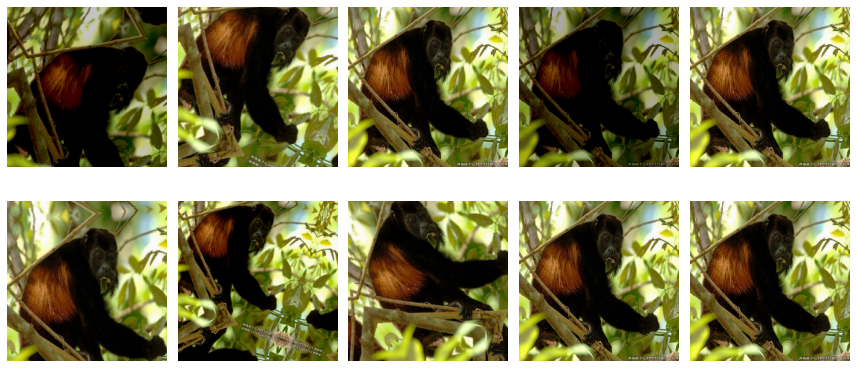

In [18]:
random.seed(42)
visualize_augmentations(train_dataset)

### Train
Выберем, что хотим сохранять в истории обучения: 


*   loss для обеих выборок (train, val)
*   accuracy 
*   F1-score + weighted agerage по классам

каждые every_epoch эпох



In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
def count_accuracy(true, pred):
    pred = torch.argmax(pred, dim=1).cpu().detach().numpy()
    true = true.cpu().detach().numpy()
    return accuracy_score(true, pred)

def count_f1(true, pred):
    pred = torch.argmax(pred, dim=1).cpu().detach().numpy()
    true = true.cpu().detach().numpy()
    return f1_score(true, pred, average='weighted')

In [21]:
def train_model(model, optimizer, loss_func, scheduler, num_epochs=40, every_epoch=5):
    
    train_history = {
        'loss': [],
        'accuracy': [],
        'f1': []
    }
    val_history = {
        'loss': [],
        'accuracy': [],
        'f1': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        # TRAIN
        print("PHASE: TRAIN")
        scheduler.step()
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])

        epoch_loss = 0
        epoch_accuracy = 0
        epoch_f1 = 0

        model.train()  # Set model to training mode

        for inputs, labels in tqdm(train_dataloader):
            inputs = inputs.float() 
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            accuracy = count_accuracy(labels, outputs)
            f1 = count_f1(labels, outputs)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.cpu().item()
            epoch_accuracy += accuracy
            epoch_f1 += f1

        if epoch % every_epoch == 0:
            epoch_loss /= len(train_dataloader)
            epoch_accuracy /= len(train_dataloader)
            epoch_f1 /= len(train_dataloader)
            train_history['loss'].append(epoch_loss)
            train_history['accuracy'].append(epoch_accuracy)
            train_history['f1'].append(epoch_f1)
            print("train_loss: ", epoch_loss)
            print("train_accuracy: ", epoch_accuracy)
            print("train_f1: ", epoch_f1)
            print("---------------------------")
        
        # VAL
        print("PHASE: VAL")
        model.eval()
        epoch_loss = 0
        epoch_accuracy = 0
        epoch_f1 = 0
        
        for inputs, labels in tqdm(val_dataloader):
            inputs=inputs.float() 
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
            
            loss = loss_func(outputs, labels)
            accuracy = count_accuracy(labels, outputs)
            f1 = count_f1(labels, outputs)

            epoch_loss += loss.cpu().item()
            epoch_accuracy += accuracy
            epoch_f1 += f1
        
        if epoch % every_epoch == 0:
            epoch_loss /= len(val_dataloader)
            epoch_accuracy /= len(val_dataloader)
            epoch_f1 /= len(val_dataloader)
            val_history['loss'].append(epoch_loss)
            val_history['accuracy'].append(epoch_accuracy)
            val_history['f1'].append(epoch_f1)
            print("val_loss: ", epoch_loss)
            print("val_accuracy: ", epoch_accuracy)
            print("val_f1: ", epoch_f1)
            print("---------------------------")
            
        if epoch_f1 > best_f1:
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, 'best_weights_'+str(epoch)+'.pkl')    
            best_f1 = epoch_f1
        
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_history, val_history

In [24]:
model = VGG16()
model.apply(weights_init_uniform)

model.to(device)
None

In [26]:
train_params = {
    'start_lr': 1e-5,
    'scheduler_step_size': 5,
    'scheduler_gamma': 0.5,
    'num_epochs': 40,
    'every_epoch': 2,
}

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=train_params['start_lr'])

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, 
                                       step_size=train_params['scheduler_step_size'], 
                                       gamma=train_params['scheduler_gamma'])
loss_func = nn.CrossEntropyLoss()

model, train_history, val_history = train_model(model, optimizer_ft, loss_func, exp_lr_scheduler, 
                                    num_epochs=train_params['num_epochs'],
                                    every_epoch = train_params['every_epoch'])

/home/user/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/40
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:18<00:00,  7.40it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.11it/s]


Epoch 2/40
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:14<00:00,  9.18it/s]


train_loss:  1.7502104287599995
train_accuracy:  0.4096715328467153
train_f1:  0.4048401112269725
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.66it/s]


val_loss:  1.2422780425233
val_accuracy:  0.5919117647058824
val_f1:  0.7027552716890951
---------------------------
Epoch 3/40
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.73it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.01it/s]


Epoch 4/40
----------
PHASE: TRAIN
LR 1e-05


100%|██████████| 137/137 [00:15<00:00,  8.95it/s]


train_loss:  1.2390258268718302
train_accuracy:  0.5812043795620438
train_f1:  0.5935914146680569
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.38it/s]


val_loss:  1.0615018633577753
val_accuracy:  0.6323529411764706
val_f1:  0.7210596388905214
---------------------------
Epoch 5/40
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.58it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.63it/s]


Epoch 6/40
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.75it/s]


train_loss:  0.8726431799195978
train_accuracy:  0.7171532846715328
train_f1:  0.7286496350364963
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.60it/s]


val_loss:  0.8300649841754314
val_accuracy:  0.7169117647058824
val_f1:  0.8070554445554446
---------------------------
Epoch 7/40
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  9.09it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.65it/s]


Epoch 8/40
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:14<00:00,  9.45it/s]


train_loss:  0.7160432071146303
train_accuracy:  0.7545620437956204
train_f1:  0.7628258602711155
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.38it/s]


val_loss:  0.7778213816037511
val_accuracy:  0.7463235294117647
val_f1:  0.8329701140362906
---------------------------
Epoch 9/40
----------
PHASE: TRAIN
LR 5e-06


100%|██████████| 137/137 [00:15<00:00,  8.57it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.61it/s]


Epoch 10/40
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  8.72it/s]


train_loss:  0.6046250900321634
train_accuracy:  0.8065693430656934
train_f1:  0.8127433090024331
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.81it/s]


val_loss:  0.7242994825835066
val_accuracy:  0.7683823529411765
val_f1:  0.8571649755473287
---------------------------
Epoch 11/40
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  9.01it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.66it/s]


Epoch 12/40
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  8.98it/s]


train_loss:  0.5423905085364398
train_accuracy:  0.8166058394160584
train_f1:  0.8219499478623564
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.63it/s]


val_loss:  0.6592652413802331
val_accuracy:  0.7757352941176471
val_f1:  0.8573813033371858
---------------------------
Epoch 13/40
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  9.00it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.65it/s]


Epoch 14/40
----------
PHASE: TRAIN
LR 2.5e-06


100%|██████████| 137/137 [00:15<00:00,  8.99it/s]


train_loss:  0.4863946972972285
train_accuracy:  0.843978102189781
train_f1:  0.85
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.47it/s]


val_loss:  0.6659235655679367
val_accuracy:  0.7904411764705882
val_f1:  0.8694175514028457
---------------------------
Epoch 15/40
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:15<00:00,  9.11it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.67it/s]


Epoch 16/40
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:15<00:00,  9.06it/s]


train_loss:  0.4368485153591546
train_accuracy:  0.8667883211678832
train_f1:  0.867504489630402
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.52it/s]


val_loss:  0.6679188972373273
val_accuracy:  0.7794117647058824
val_f1:  0.8627460366430957
---------------------------
Epoch 17/40
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:15<00:00,  8.60it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.48it/s]


Epoch 18/40
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:15<00:00,  8.66it/s]


train_loss:  0.38918126891129207
train_accuracy:  0.8941605839416058
train_f1:  0.9022332290580466
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.65it/s]


val_loss:  0.6491615535992691
val_accuracy:  0.7794117647058824
val_f1:  0.8623491296285416
---------------------------
Epoch 19/40
----------
PHASE: TRAIN
LR 1.25e-06


100%|██████████| 137/137 [00:15<00:00,  8.75it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.74it/s]


Epoch 20/40
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:14<00:00,  9.19it/s]


train_loss:  0.3601615181206352
train_accuracy:  0.8978102189781022
train_f1:  0.90286901865369
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.73it/s]


val_loss:  0.6212896463351653
val_accuracy:  0.7757352941176471
val_f1:  0.8613391102361692
---------------------------
Epoch 21/40
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:15<00:00,  8.75it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.69it/s]


Epoch 22/40
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:14<00:00,  9.19it/s]


train_loss:  0.3560163158189206
train_accuracy:  0.8895985401459854
train_f1:  0.8970824643726102
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.92it/s]


val_loss:  0.6319074448033729
val_accuracy:  0.7941176470588235
val_f1:  0.8757722261398734
---------------------------
Epoch 23/40
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:14<00:00,  9.31it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.85it/s]


Epoch 24/40
----------
PHASE: TRAIN
LR 6.25e-07


100%|██████████| 137/137 [00:14<00:00,  9.20it/s]


train_loss:  0.3668809941541539
train_accuracy:  0.8914233576642335
train_f1:  0.8956856100104277
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.81it/s]


val_loss:  0.5972652589313358
val_accuracy:  0.8088235294117647
val_f1:  0.8860375123242773
---------------------------
Epoch 25/40
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:14<00:00,  9.31it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.59it/s]


Epoch 26/40
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:15<00:00,  9.00it/s]


train_loss:  0.32137308064440306
train_accuracy:  0.9041970802919708
train_f1:  0.9121393812999652
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.70it/s]


val_loss:  0.5971600254723692
val_accuracy:  0.8051470588235294
val_f1:  0.8837966159657338
---------------------------
Epoch 27/40
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:14<00:00,  9.14it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.33it/s]


Epoch 28/40
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:15<00:00,  8.68it/s]


train_loss:  0.3673069100745403
train_accuracy:  0.8914233576642335
train_f1:  0.8982881473757385
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.72it/s]


val_loss:  0.5992419301970479
val_accuracy:  0.7977941176470589
val_f1:  0.8760320153702508
---------------------------
Epoch 29/40
----------
PHASE: TRAIN
LR 3.125e-07


100%|██████████| 137/137 [00:15<00:00,  9.12it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.59it/s]


Epoch 30/40
----------
PHASE: TRAIN
LR 1.5625e-07


100%|██████████| 137/137 [00:15<00:00,  8.88it/s]


train_loss:  0.3083885588078168
train_accuracy:  0.9151459854014599
train_f1:  0.9233663538408061
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.87it/s]


val_loss:  0.5985756529467728
val_accuracy:  0.7904411764705882
val_f1:  0.8739951429289666
---------------------------
Epoch 31/40
----------
PHASE: TRAIN
LR 1.5625e-07


100%|██████████| 137/137 [00:15<00:00,  8.91it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.61it/s]


Epoch 32/40
----------
PHASE: TRAIN
LR 1.5625e-07


100%|██████████| 137/137 [00:15<00:00,  9.02it/s]


train_loss:  0.3339874904847493
train_accuracy:  0.9005474452554745
train_f1:  0.9087996755879968
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.67it/s]


val_loss:  0.6087425506728537
val_accuracy:  0.7904411764705882
val_f1:  0.8724968250703546
---------------------------
Epoch 33/40
----------
PHASE: TRAIN
LR 1.5625e-07


100%|██████████| 137/137 [00:15<00:00,  8.92it/s]


PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.67it/s]


Epoch 34/40
----------
PHASE: TRAIN
LR 1.5625e-07


100%|██████████| 137/137 [00:16<00:00,  8.24it/s]


train_loss:  0.30114350658263606
train_accuracy:  0.9133211678832117
train_f1:  0.919838373305527
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.13it/s]


val_loss:  0.6066934500533321
val_accuracy:  0.7867647058823529
val_f1:  0.8707744053332291
---------------------------
Epoch 35/40
----------
PHASE: TRAIN
LR 7.8125e-08


100%|██████████| 137/137 [00:15<00:00,  8.69it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.31it/s]


Epoch 36/40
----------
PHASE: TRAIN
LR 7.8125e-08


100%|██████████| 137/137 [00:15<00:00,  8.79it/s]


train_loss:  0.3208528292113847
train_accuracy:  0.9105839416058394
train_f1:  0.9161250144826791
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.12it/s]


val_loss:  0.5975061365101925
val_accuracy:  0.8051470588235294
val_f1:  0.883731729871436
---------------------------
Epoch 37/40
----------
PHASE: TRAIN
LR 7.8125e-08


100%|██████████| 137/137 [00:16<00:00,  8.46it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  7.15it/s]


Epoch 38/40
----------
PHASE: TRAIN
LR 7.8125e-08


100%|██████████| 137/137 [00:15<00:00,  8.78it/s]


train_loss:  0.3036487176198594
train_accuracy:  0.916058394160584
train_f1:  0.9213257444096858
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.54it/s]


val_loss:  0.6206792729139766
val_accuracy:  0.7904411764705882
val_f1:  0.8728193579296523
---------------------------
Epoch 39/40
----------
PHASE: TRAIN
LR 7.8125e-08


100%|██████████| 137/137 [00:14<00:00,  9.23it/s]


PHASE: VAL


100%|██████████| 34/34 [00:04<00:00,  8.43it/s]


Epoch 40/40
----------
PHASE: TRAIN
LR 3.90625e-08


100%|██████████| 137/137 [00:14<00:00,  9.21it/s]


train_loss:  0.2916242481093772
train_accuracy:  0.9215328467153284
train_f1:  0.9251317923763178
---------------------------
PHASE: VAL


100%|██████████| 34/34 [00:03<00:00,  8.68it/s]

val_loss:  0.6027399421573671
val_accuracy:  0.7941176470588235
val_f1:  0.874737721428898
---------------------------


In [31]:
x = np.arange(1, 21)*2

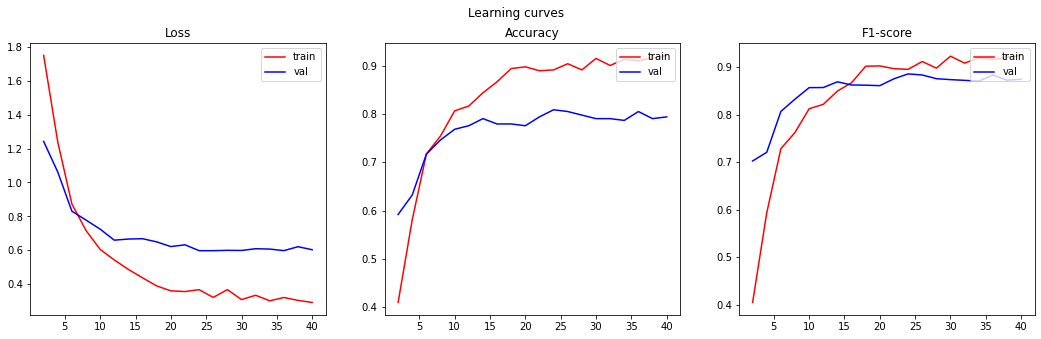

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Learning curves")
axs[0].plot(x, train_history['loss'], 'r', label = 'train')
axs[0].plot(x, val_history['loss'], 'b', label = 'val')
axs[0].legend(loc="upper right")
axs[0].set_title("Loss")
axs[1].plot(x, train_history['accuracy'], 'r', label = 'train')
axs[1].plot(x, val_history['accuracy'], 'b', label = 'val')
axs[1].legend(loc="upper right")
axs[1].set_title("Accuracy")
axs[2].plot(x, train_history['f1'], 'r', label = 'train')
axs[2].plot(x, val_history['f1'], 'b', label = 'val')
axs[2].legend(loc="upper right")
axs[2].set_title("F1-score")
None

На 27 эпохе было достигнуто плато и наилучшие метрики, так что возьмем веса с этой эпохи.

In [16]:
torch.cuda.empty_cache() 

### Test and metrics

In [52]:
def plot_conf_matrix(model, val_dataloader):
    model.eval()
    true = np.array([])
    pred = np.array([])

    for inputs, labels in tqdm(val_dataloader):
        inputs = inputs.float() 
        inputs = inputs.to(device)

        with torch.no_grad():
            outputs = model(inputs)

        true = np.append(true, labels.detach().numpy())
        pred = np.append(pred, torch.argmax(outputs, dim=1).cpu().detach().numpy())
        
    cf = confusion_matrix(true, pred)
    
    return cf

In [53]:
cf = count_conf_matrix(model, val_dataloader)

100%|██████████| 34/34 [00:03<00:00,  8.60it/s]


In [54]:
def plot_cf(cf):
    df_cm = pd.DataFrame(cf, range(10), range(10))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

    plt.show()

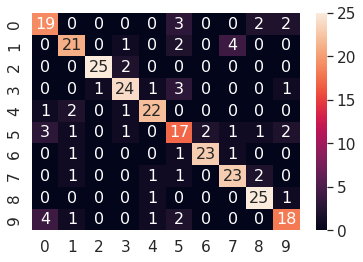

In [55]:
plot_cf(cf)

### Summary

## ResNet

## EfficientNet